In [1]:
# 导入必要的函数库
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import serial
import pylab as pl
import scipy.ndimage
import threading
import time
from matplotlib.patches import Polygon
from scipy.signal import convolve2d 
from PIL import Image
from scipy import ndimage

In [2]:
# 打开摄像头，占用内存大，不轻易运行
# capture=cv2.VideoCapture(1)

In [3]:
# 打开串口
# ser_32 = serial.Serial('/dev/ttyAMA0', 921600)
# ser_screen=serial.Serial('/dev/ttyAMA3', 115200)

In [4]:
# 获取并处理图像
def get_image():
    while True:
        # 开全局变量处理，分理处红绿蓝
        global image, image_red, image_green, image_blue
        # 从摄像头获取图像
        # _,image=capture.read()
        image=cv2.imread('1.jpg')
        image_red=image[:,:,2].astype(np.float32)
        image_green=image[:,:,1].astype(np.float32)
        image_blue=image[:,:,0].astype(np.float32)
        #cv2.imshow('image',image)
        #cv2.waitKey(1)

# 获取图像单独开进程
# get_image_threading = threading.Thread(target=get_image)
# get_image_threading.start()

In [5]:
# 发送命令，通用函数
def send_order(order, ser):
    print('order='+order)
    encoded_order = order.encode()
    ser.write(encoded_order)

In [6]:
# 获取消息，通用函数
def get_mail(ser):
    encoded_mail = ser.read(1)
    print('mail='+encoded_mail)

In [7]:
# 突出图像中的红色目标
def get_red():
    global image, image_red, image_green, image_blue
    image_red_only=image_red*2-image_blue-image_green
    image_red_only[image_red_only<0]=0
    return image_red_only

In [8]:
# 在某一图像的指定位置添加图案
kernel = np.array([
[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
[0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
[0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0],
[0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0],
[0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
[0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
])*255
def draw_image(image_gray_to_draw, kernel, kernel_point):
    try:
        image_gray_to_draw[int(kernel_point[0]-11):int(kernel_point[0]+11),int(kernel_point[1]-11):int(kernel_point[1]+11)]=kernel
    except:
        pass
    return image_gray_to_draw
# 拍照，保存一张照片
def take_photo(photo_name):
    global capture
    photo_name=photo_name+'.jpg'
    _,image=capture.read()
    cv2.imwrite(photo_name,image)
    print('take photo success')
# 展示图片
def show_image(image):
    image_show=image.astype(np.uint8)
    plt.imshow(image_show, cmap='gray')
    plt.axis('off')  # 不显示坐标轴
    plt.show()

In [9]:
# 模式匹配找车
# 这个是目标图像
# aim_image = cv2.imread('aim.png')
# 这个是目标图像的灰度图
# aim_gray = cv2.cvtColor(aim_image, cv2.COLOR_BGR2GRAY)
threshold = 0.8
def find_car_mate(image_gray):
    global car_center
    try:
        result = cv2.matchTemplate(image_gray, aim_gray, cv2.TM_CCOEFF_NORMED)
        locations = np.where(result >= threshold)
        # 转换为(x, y)坐标
        locations = list(zip(*locations[::-1]))
        # 转换为目标中心点坐标
        car_center=np.array([int(locations[0][1] + aim_image.shape[0] / 2),int(locations[0][0] + aim_image.shape[1] / 2)])
    except:
        car_center=car_center
    return(car_center)

In [10]:
# 颜色识别找车
def find_car_red(image_gray):
    global car_center
    try:
        d1=np.argwhere(image_gray[70:100,100:540] > 100)
        car_center=np.mean(d1,axis=0)
    except:
        car_center=car_center

In [11]:
# 这里默认从左到右的顺序，从上到下的顺序
grid_1=[]
label_1=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
# 定位函数，定位车在哪个格子里
def locate_car(car_center):
    # 首先找到小车在16宫格内的坐标
    car_center_M=car_center
    car_index=int(car_center_M[0]/120)*4+int(car_center_M[1]/160)
    return label_1[car_index]

In [12]:
# 我们需要将我们读取到的图像映射成一个平整的图像
ex1=cv2.imread('good.jpg')
ex1_grey=cv2.cvtColor(ex1, cv2.COLOR_BGR2GRAY)
grid=cv2.imread('grid.jpg')
grid_grey=cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)
ad=cv2.imread('grid.jpg')
ad_grey=cv2.cvtColor(ad, cv2.COLOR_BGR2GRAY)

In [13]:
ad.shape

(968, 968, 3)

In [14]:
968/4

242.0

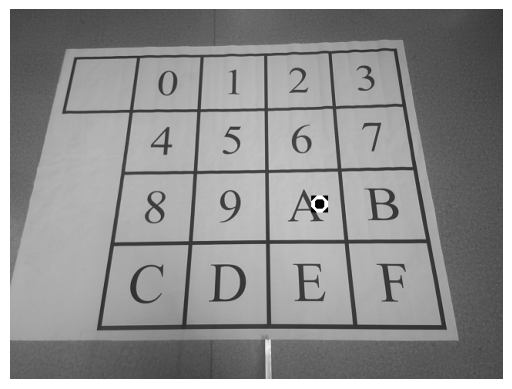

[846.862779   780.36112023   1.30118841]


In [15]:
M=np.load('M.npy')
ex1_grey2=ex1_grey.copy()
# pts0=np.float32([[63,165],[413,116],[413,562],[53,502]])
show_image(draw_image(ex1_grey2, kernel, [253,402]))
a=np.array([402,253,1])
now_position=np.dot(M,a)
print(now_position)

In [16]:
print(type(M))

<class 'numpy.ndarray'>


In [17]:
M=np.save('M.npy',M)

In [18]:
M=np.load('M.npy')

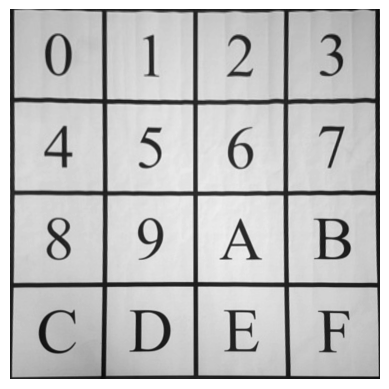

In [19]:
# 我们需要将我们读取到的图像映射成一个平整的图像
# 对应原先图像的，左上，左下，右下，右上，四个点
pts0=np.float32([[63,165],[413,116],[413,562],[53,502]])
# 建立映射需要的一一对应
pts1=np.float32([[pts0[0][1],pts0[0][0]],[pts0[3][1],pts0[3][0]],[pts0[2][1],pts0[2][0]],[pts0[1][1],pts0[1][0]]])
# 对应映射后图像，左上，左下，右下，右上，四个点
pts2=np.float32([[0,0],[968,0],[968,968],[0,968]])
# 生成最为关键的变换矩阵
M = cv2.getPerspectiveTransform(pts1,pts2)
# 变换正方形
square_trans = cv2.warpPerspective(ex1_grey,M,(grid.shape[1],grid.shape[0]))
show_image(square_trans)

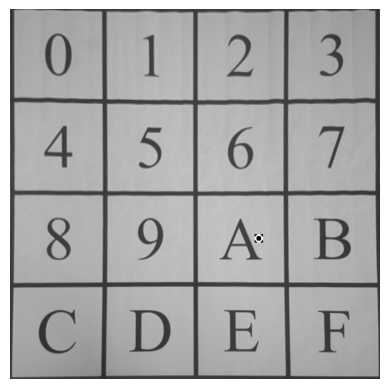

In [20]:
square_trans3=square_trans.copy()
show_image(draw_image(square_trans3, kernel, [780.0/1.3,847.0/1.3]))

In [21]:
# 图像的映射变换
def photo_transform(ad,origin,border_point):
    # 原先的四个角的边缘点
    pts = np.float32([[0,0],[0,origin.shape[1]],[origin.shape[0],origin.shape[1]],[origin.shape[0],0]])
    # 由于变换的特殊性，这里后面的点是列行，反着来的
    border_point_1=np.zeros(np.shape(border_point))
    border_point_1[:,0]=border_point[:,1]
    border_point_1[:,1]=border_point[:,0]
    pts1 = np.float32(border_point_1)
    # 生成最为关键的变换矩阵
    M = cv2.getPerspectiveTransform(pts,pts1)
    # 变换正方形
    square_trans = cv2.warpPerspective(origin,M,(ad.shape[1],ad.shape[0]))
    square_trans = cv2.cvtColor(square_trans, cv2.COLOR_RGB2GRAY)
    _, square_trans = cv2.threshold(square_trans, 127, 255, cv2.THRESH_BINARY)
    return square_trans

In [22]:
s=0
# take_photo('good')

In [23]:
# take_photo(f'{s}')
s+=1

In [24]:
PBL=b'A14'
aim_point21=(PBL[1]-48)*10+(PBL[2]-48)


In [25]:
road21=[]
for i in range(aim_point21%4+1):
    road21.append(i)
for i in range(1,aim_point21//4+1):
    road21.append(aim_point21%4+4*i)

In [26]:
road21_send=[]
for i in road21:
    p='P'+str(int(i/10))+str(i%10)
    road21_send.append(p)
road21_send.append('STOP')
print(road21_send)

['P00', 'P01', 'P02', 'P06', 'P10', 'P14', 'STOP']


In [27]:
# road21=[]
# road21_send=[]
# for i in range(aim_point21%4+1):
#     road21.append(i)
# for i in range(1,aim_point21//4+1):
#     road21.append(aim_point21%4+4*i)
# for i in road21:
#     p='P'+str(int(i/10))+str(i%10)
#     road21_send.append(p)
# road21_send.append('STOP')
# print(road21_send)
# # 此时已完成路径点的确定，发送给stm32
# for i in road21_send:
#     send_order(i, ser_32)